In [24]:
import numpy as np
import matplotlib.pyplot as plt
import random
import math

In [94]:
alphabet = ["a","b","c","d","e","f","g","h","i","j","k","l","m","n","o","p","q","r","s","t","u","v","w","x","y","z"," ","."]

with open('data/sample/ciphertext.txt', 'r', encoding='utf-8') as f:
    ciphertext = f.read()

P = np.loadtxt("data/letter_probabilities.csv", delimiter = ",")
M = np.loadtxt("data/letter_transition_matrix.csv", delimiter = ",")

inverse_perm = {c: i for i, c in enumerate(permutation)}
print(inverse_perm)


# r to m

{'i': 0, 'u': 1, 'x': 2, 'q': 3, 'g': 4, 't': 5, 'm': 6, 'h': 7, ' ': 8, 'k': 9, 'w': 10, 'a': 11, '.': 12, 'b': 13, 'v': 14, 'l': 15, 'p': 16, 'e': 17, 'r': 18, 'j': 19, 's': 20, 'z': 21, 'o': 22, 'c': 23, 'f': 24, 'y': 25, 'd': 26, 'n': 27}


In [ ]:
#MH MCMC Algorithm
def log_likelihood(perm, txt):
    inverse_perm = {c: i for i, c in enumerate(perm)}

    log_lik = 0

    for i, char in enumerate(txt):
        decoded_char_idx = inverse_perm[char]

        if i == 0:
            log_lik += np.log(P[decoded_char_idx])

        else:
            prev_decoded_char_idx = inverse_perm[txt[i-1]]

            if M[decoded_char_idx][prev_decoded_char_idx] == 0:
                return float('-inf')

            log_lik += np.log(M[decoded_char_idx][prev_decoded_char_idx])

    return log_lik

def propose_new_permutation(perm):
    i, j = random.sample(range(len(perm)), 2)
    new_perm = perm.copy()
    new_perm[i], new_perm[j] = new_perm[j], new_perm[i]
    return new_perm


def MH(T):
    permutation = random.sample(alphabet, len(alphabet))
    f_star = permutation
    L_star = log_likelihood(permutation, ciphertext)

    f_prev = permutation

    for i in range(T):
        fprime = propose_new_permutation(f_prev)

        old_ll = log_likelihood(f_prev, ciphertext)
        new_ll = log_likelihood(fprime, ciphertext)

        if old_ll == float('-inf'):
            bernoulli_param = 1
        else:
            bernoulli_param = min(1, np.exp(new_ll-old_ll))

        if random.random() < bernoulli_param:

            if new_ll > L_star:
                L_star = new_ll
                f_star = fprime

            f_prev = fprime

    return L_star, f_star
    

(-inf, ['u', '.', 'i', 'q', 'y', 'a', 'd', 'c', 'g', 'l', 'f', 'm', 'v', 'r', 'e', 'x', 'z', 'n', 'k', ' ', 'h', 't', 's', 'o', 'p', 'j', 'b', 'w'])


In [109]:
K = len(alphabet)
char2idx = {c:i for i,c in enumerate(alphabet)}
C = np.array([char2idx[c] for c in ciphertext], dtype=int)

eps  = 1e-8
P_s  = P + eps; P_s /= P_s.sum()
M_s  = M + eps; M_s /= M_s.sum(axis=0, keepdims=True)
logP = np.log(P_s)
logM = np.log(M_s)

def log_likelihood(perm, C):
    D = perm[C]
    return logP[D[0]] + logM[D[1:], D[:-1]].sum()

def propose(perm):
    i, j = random.randrange(K), random.randrange(K)
    perm2 = perm.copy()
    perm2[i], perm2[j] = perm2[j], perm2[i]
    return perm2

def MH_good(T):
    performance = []
    perm = np.random.permutation(K)
    ll_prev = log_likelihood(perm, C)
    best, best_ll = perm.copy(), ll_prev

    for _ in range(T):
        cand    = propose(perm)
        ll_cand = log_likelihood(cand, C)

        diff = ll_cand - ll_prev
        alpha = 1.0 if diff >= 0 else np.exp(diff)

        if random.random() < alpha:
            perm, ll_prev = cand, ll_cand
            if ll_cand > best_ll:
                best_ll, best = ll_cand, cand.copy()

        performance.append(best_ll)

    return best_ll, best, performance


In [115]:
_,_,p = MH_good(5000)

print(p)

[np.float64(-33539.42336675207), np.float64(-31878.870743629013), np.float64(-31525.077372133677), np.float64(-31525.077372133677), np.float64(-31525.077372133677), np.float64(-31525.077372133677), np.float64(-31360.224957637114), np.float64(-31360.224957637114), np.float64(-31360.224957637114), np.float64(-31360.224957637114), np.float64(-31360.224957637114), np.float64(-27799.091960624562), np.float64(-27799.091960624562), np.float64(-27799.091960624562), np.float64(-26674.391235442334), np.float64(-26674.391235442334), np.float64(-26458.026106025496), np.float64(-26458.026106025496), np.float64(-26458.026106025496), np.float64(-26458.026106025496), np.float64(-26458.026106025496), np.float64(-26458.026106025496), np.float64(-26389.130732558722), np.float64(-26389.130732558722), np.float64(-26389.130732558722), np.float64(-26389.130732558722), np.float64(-26389.130732558722), np.float64(-26389.130732558722), np.float64(-26389.130732558722), np.float64(-26389.130732558722), np.float64

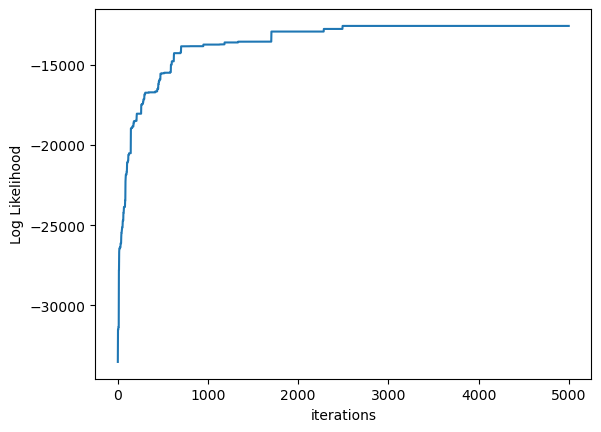

In [118]:
plt.figure()
plt.plot(p)   # add markers if you like
plt.xlabel('iterations')
plt.ylabel('Log Likelihood')

plt.show()